# 1. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set_theme(style="whitegrid", palette="deep", font_scale=1.5)

SEED = 42

In [2]:
train_q = pd.read_excel("data/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx")
train_c = pd.read_excel("data/TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx")
test_q = pd.read_excel("data/TEST/TEST_QUANTITATIVE_METADATA.xlsx")
test_c = pd.read_excel("data/TEST/TEST_CATEGORICAL_METADATA.xlsx")

train_combined = pd.merge(train_q, train_c, on='participant_id', how='left').set_index("participant_id")
test_combined = pd.merge(test_q, test_c, on='participant_id', how='left').set_index("participant_id")

labels = pd.read_excel("data/TRAIN/TRAINING_SOLUTIONS.xlsx").set_index('participant_id')

train_combined = train_combined.sort_index()
test_combined = test_combined.sort_index()
labels = labels.sort_index()
assert all(train_combined.index == labels.index), "error"

In [3]:
train_combined.head()

,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,...,MRI_Track_Age_at_Scan,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
participant_id,,,,,,,,,,,,,,,,,,,,,
00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,...,14.274127,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN
00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,...,NaN,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0
04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,24.0,...,13.463381,2017,1,1.0,2.0,2.0,9.0,0.0,NaN,NaN
05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,...,9.572553,2018,1,3.0,8.0,2.0,18.0,10.0,18.0,0.0
06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,...,6.654574,2018,1,0.0,1.0,2.0,12.0,0.0,NaN,NaN


In [4]:
print(train_combined.columns)
print(len(train_combined.columns))

Index(['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
       'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan',
       'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ'],
      dtype='object')
27


# 2. Data Preprocessing
This is some explanation of feature present in the dataset

## 2.1 Numerical features: Total of 18 features
+ EHQ_EHQ_Total: laterality index score (float) || -100 = 10th left, −28 ≤ LI < 48 = middle, 100 = 10th right"
+ ColorVision_CV_Score: color vision test score (int)
+ MRI_Track_Age_at_Scan: Age at time of MRI scan (float)

### ALABAMA PARENTING QUESTIONAIRE - PARENT REPORT (INT)
+ APQ_P_APQ_P_CP: Reflects the frequency or severity of corporal punishment used by parents
+ APQ_P_APQ_P_ID: Measures inconsistency in parental discipline
+ APQ_P_APQ_P_INV: Indicates the level of parental involvement in the child’s life
+ APQ_P_APQ_P_OPD: Other Discipline Practices Score (Not factored into total score but provides item level information)
+ APQ_P_APQ_P_PM: Reflects how well a parent monitors and supervises their child
+ APQ_P_APQ_P_PP: Captures the extent of positive reinforcement and supportive parenting

### Strength and Difficulties Questionnaire (INT)
+ SDQ_SDQ_Conduct_Problems: Measures behavioral issues related to rule-breaking or aggression (higher score = more prone to ADHD)
+ SDQ_SDQ_Difficulties_Total: A composite measure summarizing overall difficulties across several behavioral domains
+ SDQ_SDQ_Emotional_Problems: Focuses on internal emotional difficulties such as anxiety or depression (social related)
+ SDQ_SDQ_Externalizing: Captures outward-directed behaviors such as hyperactivity, impulsivity, and conduct issues
+ SDQ_SDQ_Generating_Impact: This might reflect the overall impact of the child’s behavioral problems on their social and academic life
+ SDQ_SDQ_Hyperactivity: Directly measures the hyperactive and impulsive behaviors central to many ADHD diagnoses (HIGHLY CORRELATED FEATURE)
+ SDQ_SDQ_Internalizing: Reflects inward-focused behaviors such as social withdrawal and anxiety
+ SDQ_SDQ_Peer_Problems: Assesses difficulties in interacting with peers
+ SDQ_SDQ_Prosocial: Evaluates positive social behaviors like empathy and cooperation

## 2.2 Categorical Features Visualization: Total of 10 features (already label encoded)

+ Basic_Demos_Enroll_Year: the year when the participant enrolled in the study (int) (Nomial)
+ Basic_Demos_Study_Site: Location/site where the subject was assessed (Nomial)
+ PreInt_Demos_Fam_Child_Ethnicity: Ethnic background of the child (nomial)
+ PreInt_Demos_Fam_Child_Race: Race of the child (nomial)
+ MRI_Track_Scan_Location: Where the MRI was performed (nomial)
+ Barratt_Barratt_P1_Edu: education of the parent 1 (ORDINAL)
+ Barratt_Barratt_P1_Occ: occupation of parent 1 (ORDINAL)
+ Barratt_Barratt_P2_Edu: education of the parent 2 (ORDINAL)
+ Barratt_Barratt_P2_Occ: occupation of parent 2 (ORDINAL)
+ Laterality_Category: Categorical brain lateralization: left, middle, or right

## 2.3 fMRI Connectome Matrices
+ Dimensionality Reduction: Apply techniques like Principal Component Analysis (PCA), Independent Component Analysis (ICA), or Uniform Manifold Approximation and Projection (UMAP) to the flattened connectome matrices before applying other feature selection methods or feeding them into models like Logistic Regression or standard Tree-based algorithms. Deep Learning models might handle the high dimensionality better directly.

In [5]:
numerical_features = [
    'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
    'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
    'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
    'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
    'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
    'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
    'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan'
]
print(len(numerical_features))

18


In [6]:
train_nan_counts = train_combined[numerical_features].isnull().sum()
train_nan_counts

EHQ_EHQ_Total                  13
ColorVision_CV_Score           23
APQ_P_APQ_P_CP                 12
APQ_P_APQ_P_ID                 12
APQ_P_APQ_P_INV                12
APQ_P_APQ_P_OPD                12
APQ_P_APQ_P_PM                 12
APQ_P_APQ_P_PP                 12
SDQ_SDQ_Conduct_Problems        9
SDQ_SDQ_Difficulties_Total      9
SDQ_SDQ_Emotional_Problems      9
SDQ_SDQ_Externalizing           9
SDQ_SDQ_Generating_Impact       9
SDQ_SDQ_Hyperactivity           9
SDQ_SDQ_Internalizing           9
SDQ_SDQ_Peer_Problems           9
SDQ_SDQ_Prosocial               9
MRI_Track_Age_at_Scan         360
dtype: int64

In [7]:
features_for_median_impute = [
    'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
    'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
    'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
    'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
    'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
    'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
    'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial'
    # Note: 'MRI_Track_Age_at_Scan' is excluded here
]

for feature in features_for_median_impute:
    train_medians_subset = train_combined[feature].median()
    # print(train_medians_subset, feature)
    
    train_combined[features_for_median_impute] = train_combined[features_for_median_impute].fillna(train_medians_subset)
    
    test_medians_subset = test_combined[feature].median()
    test_combined[features_for_median_impute] = test_combined[features_for_median_impute].fillna(test_medians_subset)

In [8]:
numeric_data = train_combined[numerical_features].copy()
imputer = IterativeImputer(estimator=LassoCV(random_state=SEED), max_iter=100, random_state=SEED)

numeric_data_imputed = pd.DataFrame(
    imputer.fit_transform(numeric_data),
    columns=numerical_features,
    index=numeric_data.index
)

train_combined['MRI_Track_Age_at_Scan'] = numeric_data_imputed['MRI_Track_Age_at_Scan']

In [9]:
test_numeric_data = test_combined[numerical_features].copy()

test_numeric_data_imputed = pd.DataFrame(
    imputer.transform(test_numeric_data),
    columns=numerical_features,
    index=test_numeric_data.index
)

test_combined['MRI_Track_Age_at_Scan'] = test_numeric_data_imputed['MRI_Track_Age_at_Scan']

In [10]:
def categorize_laterality(li):
    if -110 <= li <= -28:
        return "Left-Lateralized"
    elif -28 < li <= 47:
        return 'Middle'
    elif 47 < li <= 110:
        return 'Right-Lateralized'

train_combined['Laterality_Category'] = train_combined['EHQ_EHQ_Total'].apply(categorize_laterality)
test_combined['Laterality_Category'] = test_combined['EHQ_EHQ_Total'].apply(categorize_laterality)

In [11]:
categorical_features = [
    'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
    'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
    'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
    'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
    'Barratt_Barratt_P2_Occ', 'Laterality_Category',
]
print(len(categorical_features))   

10


In [12]:
train_nan_counts = train_combined[categorical_features].isnull().sum()
train_nan_counts

Basic_Demos_Enroll_Year               0
Basic_Demos_Study_Site                0
PreInt_Demos_Fam_Child_Ethnicity     43
PreInt_Demos_Fam_Child_Race          54
MRI_Track_Scan_Location               3
Barratt_Barratt_P1_Edu               15
Barratt_Barratt_P1_Occ               31
Barratt_Barratt_P2_Edu              198
Barratt_Barratt_P2_Occ              222
Laterality_Category                   0
dtype: int64

In [13]:
for feature in categorical_features:
    if feature in train_combined.columns:
        unique_values = train_combined[feature].unique()
        print(f"\nFeature: '{feature}'")
        print(f"Unique values: {unique_values}")


Feature: 'Basic_Demos_Enroll_Year'
Unique values: [2019 2017 2018 2016 2015 2020]

Feature: 'Basic_Demos_Study_Site'
Unique values: [4 1 2 3]

Feature: 'PreInt_Demos_Fam_Child_Ethnicity'
Unique values: [ 1.  0.  3.  2. nan]

Feature: 'PreInt_Demos_Fam_Child_Race'
Unique values: [ 0.  9.  2.  8.  1. 10.  4. nan  3. 11.  7.]

Feature: 'MRI_Track_Scan_Location'
Unique values: [ 3.  2.  1.  4. nan]

Feature: 'Barratt_Barratt_P1_Edu'
Unique values: [21.  9. 18. 12. 15.  3. nan  6.]

Feature: 'Barratt_Barratt_P1_Occ'
Unique values: [45.  0. 10. 35. 40. 25. nan 30. 15.  5. 20.]

Feature: 'Barratt_Barratt_P2_Edu'
Unique values: [nan 21. 18. 15. 12.  9.  6.  3.]

Feature: 'Barratt_Barratt_P2_Occ'
Unique values: [nan 45.  0. 30. 40. 15. 35.  5. 10. 20. 25.]

Feature: 'Laterality_Category'
Unique values: ['Right-Lateralized' 'Middle' 'Left-Lateralized']


In [ ]:
feature_1 = 'Basic_Demos_Enroll_Year'
train_combined[feature_1] = train_combined[feature_1].replace(2015, 2016)
test_combined[feature_1] = test_combined[feature_1].replace(2015, 2016)
train_combined[feature_1] = train_combined[feature_1].replace(2020, 2019)
test_combined[feature_1] = test_combined[feature_1].replace(2020, 2019)

plt.figure(figsize=(12, 6))
sns.countplot(data=train_combined, x='Basic_Demos_Enroll_Year', palette='Set2')
plt.title(f"Distribution of {feature_1}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

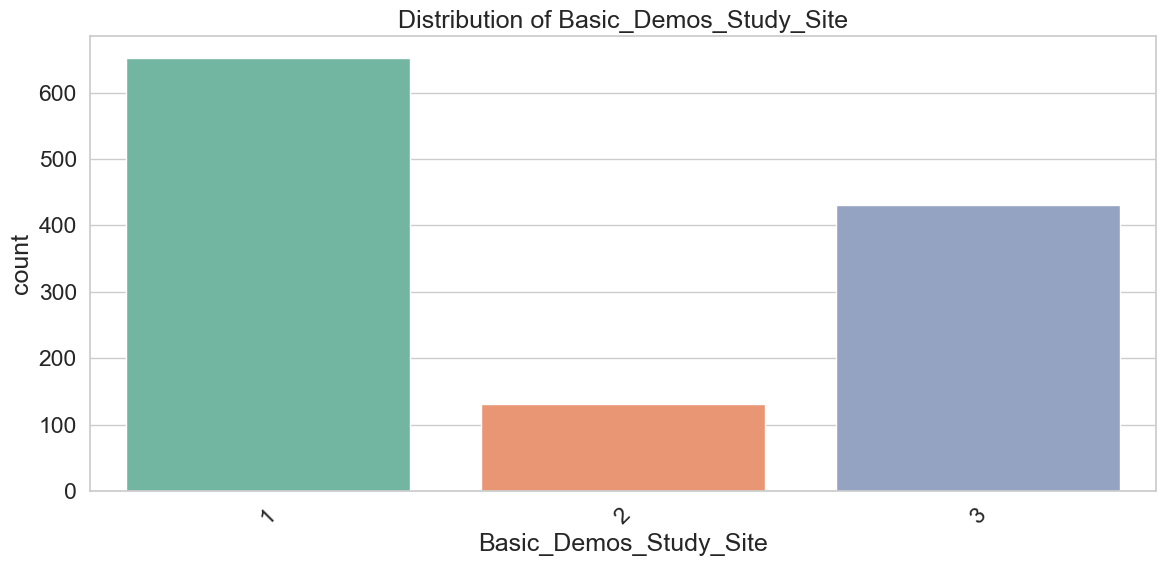

In [15]:
# Could collapse into only 2 classes 
feature_2 = 'Basic_Demos_Study_Site'
train_combined[feature_2] = train_combined[feature_2].replace(4, 2)
test_combined[feature_2] = test_combined[feature_2].replace(4, 2)

plt.figure(figsize=(12, 6))
sns.countplot(data=train_combined, x='Basic_Demos_Study_Site', palette='Set2')
plt.title(f"Distribution of {feature_2}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

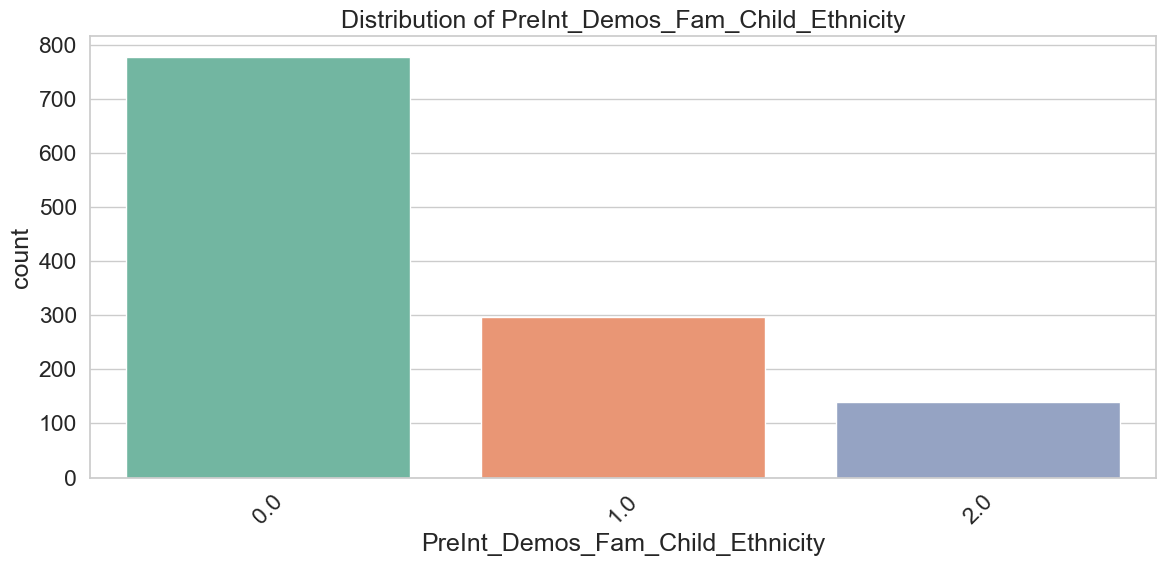

In [16]:
feature_3 = "PreInt_Demos_Fam_Child_Ethnicity"
train_combined[feature_3] = train_combined[feature_3].fillna(3.0)
test_combined[feature_3] = test_combined[feature_3].fillna(3.0)

train_combined[feature_3] = train_combined[feature_3].replace({3: 2})
test_combined[feature_3] = test_combined[feature_3].replace({3: 2})

plt.figure(figsize=(12, 6))
sns.countplot(data=train_combined, x='PreInt_Demos_Fam_Child_Ethnicity', palette='Set2')
plt.title(f"Distribution of {feature_3}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

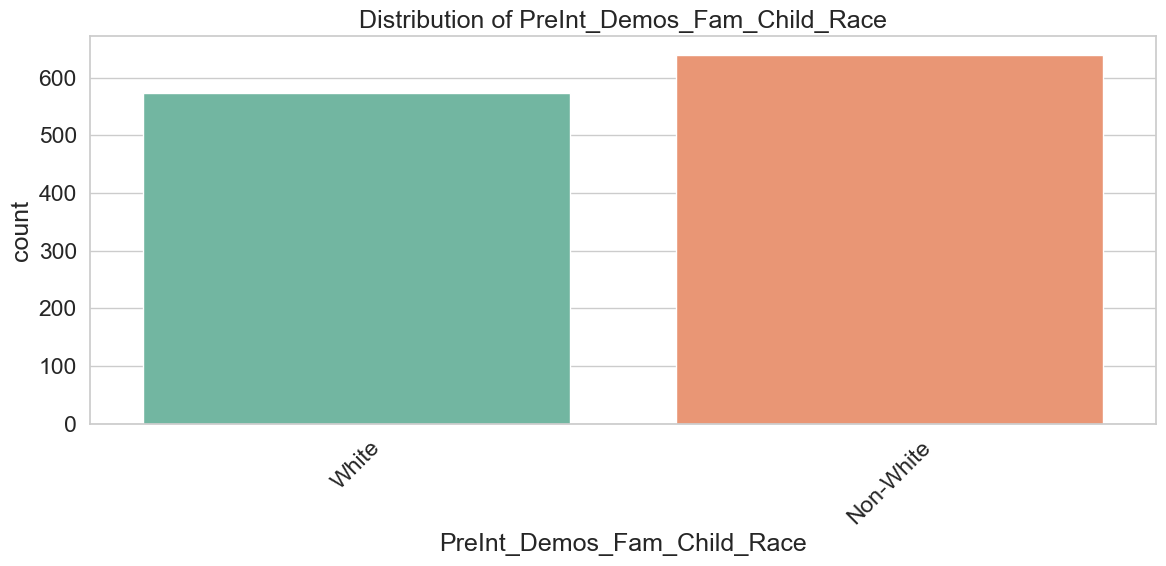

In [17]:
feature_4 = 'PreInt_Demos_Fam_Child_Race'
train_combined[feature_4] = train_combined[feature_4].fillna(10.0)
test_combined[feature_4] = test_combined[feature_4].fillna(10.0)

train_combined[feature_4] = train_combined[feature_4].apply(
    lambda x: "White" if x == 0.0 else "Non-White"
)

test_combined[feature_4] = test_combined[feature_4].apply(
    lambda x: 'White' if x == 0.0 else 'Non-White'
)

plt.figure(figsize=(12, 6))
sns.countplot(data=train_combined, x='PreInt_Demos_Fam_Child_Race', palette='Set2')
plt.title(f"Distribution of {feature_4}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

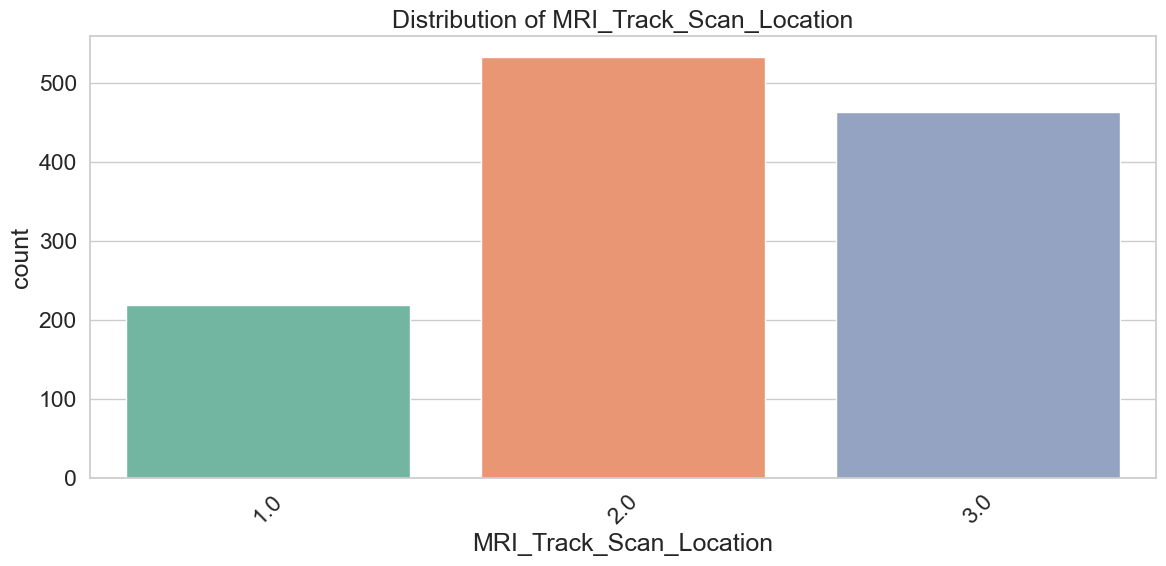

In [18]:
feature_5 = "MRI_Track_Scan_Location"
train_combined[feature_5] = train_combined[feature_5].fillna(1.0)   
test_combined[feature_5] = test_combined[feature_5].fillna(1.0)

train_combined[feature_5] = train_combined[feature_5].replace({4: 1})
test_combined[feature_5] = test_combined[feature_5].replace({4: 1})

plt.figure(figsize=(12, 6))
sns.countplot(data=train_combined, x='MRI_Track_Scan_Location', palette='Set2')
plt.title(f"Distribution of {feature_5}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

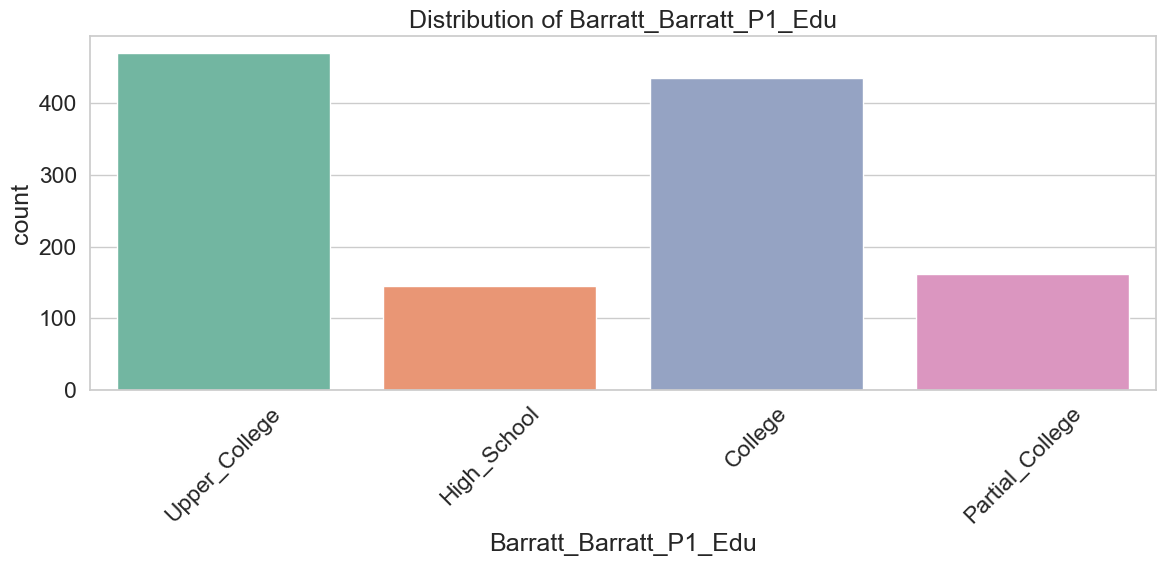

In [19]:
feature_6 = "Barratt_Barratt_P1_Edu"
train_combined[feature_6] = train_combined[feature_6].fillna(18.0)
test_combined[feature_6] = test_combined[feature_6].fillna(18.0)

def collapse_edu(value):
    if value == 21.0:
        return "Upper_College"
    elif value == 18.0:
        return "College"
    elif value == 15.0:
        return "Partial_College"
    else:
        return "High_School"
    
train_combined[feature_6] = train_combined[feature_6].apply(collapse_edu)
test_combined[feature_6] = test_combined[feature_6].apply(collapse_edu)

plt.figure(figsize=(12, 6))
sns.countplot(data=train_combined, x="Barratt_Barratt_P1_Edu", palette='Set2')
plt.title(f"Distribution of {feature_6}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
feature_7 = "Barratt_Barratt_P1_Occ"

median_train_value = train_combined[feature_7].median()
median_test_value = test_combined[feature_7].median()

train_combined[feature_7] = train_combined[feature_7].fillna(median_train_value)
test_combined[feature_7] = test_combined[feature_7].fillna(median_test_value)

In [21]:
feature_8 = "Barratt_Barratt_P2_Edu"

train_combined[feature_8] = train_combined[feature_8].apply(collapse_edu)
test_combined[feature_8] = test_combined[feature_8].apply(collapse_edu)

In [22]:
def impute_p2_edu(row):
    if pd.isna(row['Barratt_Barratt_P2_Edu']):
        return row['Barratt_Barratt_P1_Edu']
    return row['Barratt_Barratt_P2_Edu']

train_combined['Barratt_Barratt_P2_Edu'] = train_combined.apply(impute_p2_edu, axis=1)
test_combined['Barratt_Barratt_P2_Edu'] = test_combined.apply(impute_p2_edu, axis=1)

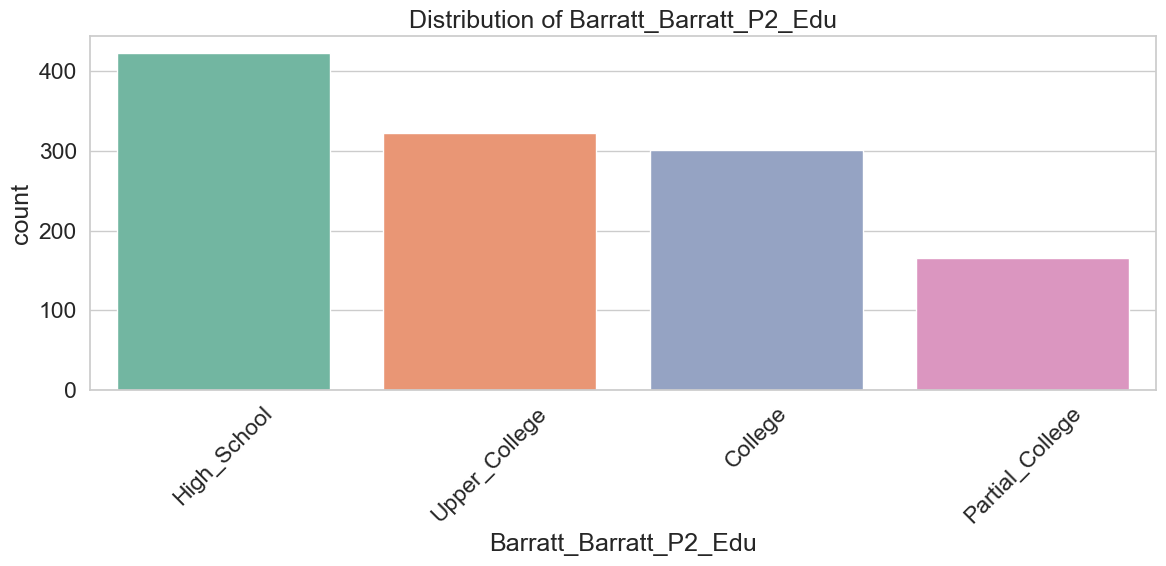

In [23]:
plt.figure(figsize=(12, 6))
sns.countplot(data=train_combined, x="Barratt_Barratt_P2_Edu", palette='Set2')
plt.title(f"Distribution of {feature_8}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
feature_9 = "Barratt_Barratt_P2_Occ"

def impute_p2_occ(row):
    if pd.isna(row['Barratt_Barratt_P2_Occ']):
        return row['Barratt_Barratt_P1_Occ']
    return row['Barratt_Barratt_P2_Occ']

train_combined['Barratt_Barratt_P2_Occ'] = train_combined.apply(impute_p2_occ, axis=1)
test_combined['Barratt_Barratt_P2_Occ'] = test_combined.apply(impute_p2_occ, axis=1)

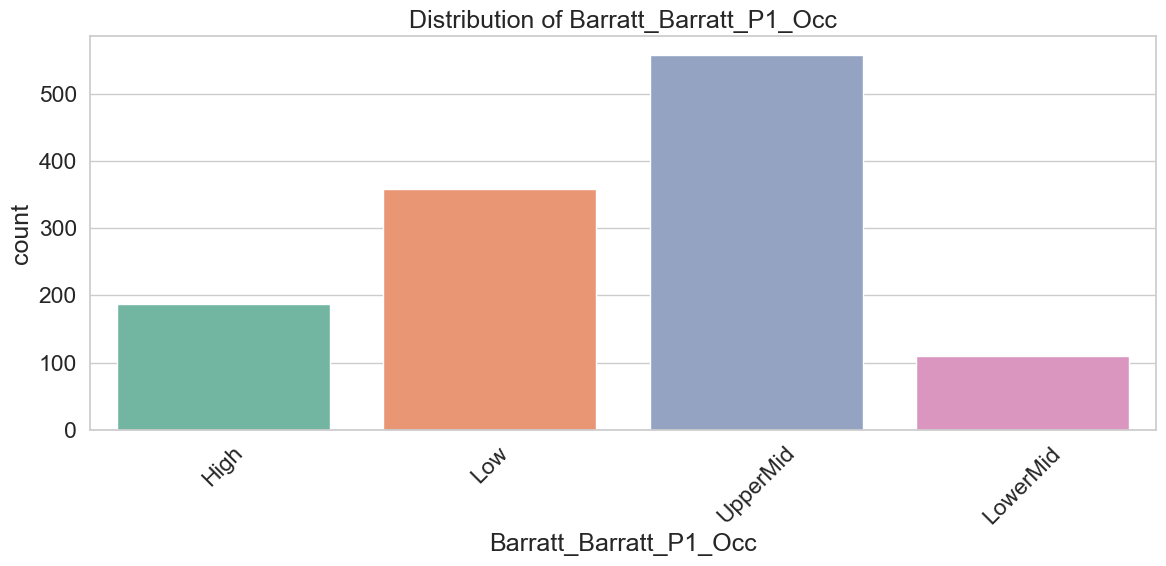

In [25]:
def collapse_occupation(val):
    if val in [0.0, 5.0, 10.0, 15.0]:
        return "Low"
    elif val in [20.0, 25.0]:
        return "LowerMid"
    elif val in [30.0, 35.0, 40.0]:
        return "UpperMid"
    elif val == 45.0:
        return "High"
    else:
        return "Other"  # Safety fallback
    
train_combined[feature_7] = train_combined[feature_7].apply(collapse_occupation)
test_combined[feature_7] = test_combined[feature_7].apply(collapse_occupation)

plt.figure(figsize=(12, 6))
sns.countplot(data=train_combined, x="Barratt_Barratt_P1_Occ", palette='Set2')
plt.title(f"Distribution of {feature_7}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

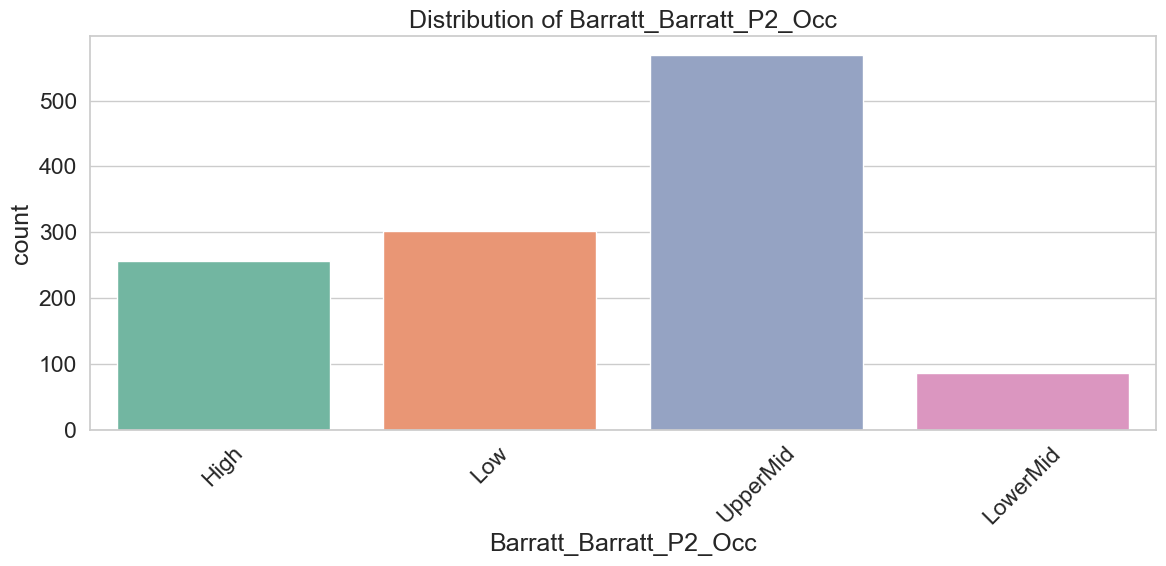

In [26]:
train_combined[feature_9] = train_combined[feature_9].apply(collapse_occupation)
test_combined[feature_9] = test_combined[feature_9].apply(collapse_occupation)

plt.figure(figsize=(12, 6))
sns.countplot(data=train_combined, x="Barratt_Barratt_P2_Occ", palette='Set2')
plt.title(f"Distribution of {feature_9}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
# One-hot encode nominal features
nominal_cols = [
    'Basic_Demos_Enroll_Year',
    'Basic_Demos_Study_Site',
    'PreInt_Demos_Fam_Child_Ethnicity',
    'PreInt_Demos_Fam_Child_Race',
    'MRI_Track_Scan_Location',
    'Laterality_Category'
]

train_combined = pd.get_dummies(train_combined, columns=nominal_cols, drop_first=True, dtype=int)
test_combined = pd.get_dummies(test_combined, columns=nominal_cols, drop_first=True, dtype=int)

# Align columns
train_combined, test_combined = train_combined.align(test_combined, join='left', axis=1, fill_value=0)

In [28]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_map = {
    'Barratt_Barratt_P1_Edu': ['High_School', 'Partial_College', 'College', 'Upper_College'],
    'Barratt_Barratt_P2_Edu': ['High_School', 'Partial_College', 'College', 'Upper_College'],
    'Barratt_Barratt_P1_Occ': ['Low', 'LowerMid', 'UpperMid', 'High'],
    'Barratt_Barratt_P2_Occ': ['Low', 'LowerMid', 'UpperMid', 'High']
}

ordinal_cols = list(ordinal_map.keys())
categories = [ordinal_map[col] for col in ordinal_cols]

encoder = OrdinalEncoder(categories=categories)

train_combined[ordinal_cols] = encoder.fit_transform(train_combined[ordinal_cols])
test_combined[ordinal_cols] = encoder.transform(test_combined[ordinal_cols])

In [29]:
train_combined.columns

Index(['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
       'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan',
       'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ',
       'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ',
       'Basic_Demos_Enroll_Year_2017', 'Basic_Demos_Enroll_Year_2018',
       'Basic_Demos_Enroll_Year_2019', 'Basic_Demos_Study_Site_2',
       'Basic_Demos_Study_Site_3', 'PreInt_Demos_Fam_Child_Ethnicity_1.0',
       'PreInt_Demos_Fam_Child_Ethnicity_2.0',
       'PreInt_Demos_Fam_Child_Race_White', 'MRI_Track_Scan_Location_2.0',
       'MRI_Track_Scan_Location_3.0', 'Laterality_Category_Middle',
       'Laterali

In [30]:
train_combined.to_csv("train_proccessed.csv", index=False)
test_combined.to_csv("test_proccessed.csv", index=False)

# 3. Feature Engineering (Model-Agnostic)

## Inter-feature correlation 
You might keep only one feature from a highly correlated group, perhaps the one more strongly correlated with the targets or based on domain knowledge. This is particularly important for Logistic Regression which is sensitive to multicollinearity.

+ Covariance matrix: symmetric and positive semidefinite and tells us about the spread of the data => Plot the correlation matrix

## Correlation with targets
+ (Numerical features): The Pearson's correlation coefficient is often used, which is a normalized version of covariance that ranges from -1 to +1, providing a more standardized measure of the strength and direction of the linear relationship. This indicator only captures the linear relationship between variables. It is worth noting that when categorical features are encoded and they are NOMIAL, a low p-value might not reflect fully its influence
Solution: non-linear transformation, interaction features, feature combinations (arithmetic), domain knowledge 

+ (Numerical and categorical features) Mutual information: Captures the statistical dependence between two random variables. Unlike correlation, MI can capture both linear and non-linear relationships. A higher MI score indicates a stronger dependency between the nominal feature and the categorical target.

## Statistical Tests
+ ANOVA F-test: For numerical features vs. each categorical target. Tests if the mean of the numerical feature differs significantly across the target groups (e.g., mean age for ADHD vs. non-ADHD). A significant p-value suggests relevance.

+ Chi-Squared Test: For categorical features (like `PreInt_Demos_Fam_Child_Race`, `Laterality_Category`) vs. each categorical target. Tests for independence between the feature and the target. A significant p-value suggests dependence/relevance.

## Solution
Variance Threshold: Remove features with very low variance. These features are nearly constant and thus provide little predictive information. Be cautious with numerical features if they haven't been scaled.

A feature might be considered important if it shows relevance (high correlation/MI, significant test) to either `ADHD_Outcome` or `Sex_F`. You can rank features based on their scores for each target and combine the rankings or set thresholds.

In [37]:
train_combined.columns

Index(['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
       'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan',
       'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ',
       'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ',
       'Basic_Demos_Enroll_Year_2017', 'Basic_Demos_Enroll_Year_2018',
       'Basic_Demos_Enroll_Year_2019', 'Basic_Demos_Study_Site_2',
       'Basic_Demos_Study_Site_3', 'PreInt_Demos_Fam_Child_Ethnicity_1.0',
       'PreInt_Demos_Fam_Child_Ethnicity_2.0',
       'PreInt_Demos_Fam_Child_Race_White', 'MRI_Track_Scan_Location_2.0',
       'MRI_Track_Scan_Location_3.0', 'Laterality_Category_Middle',
       'Laterali

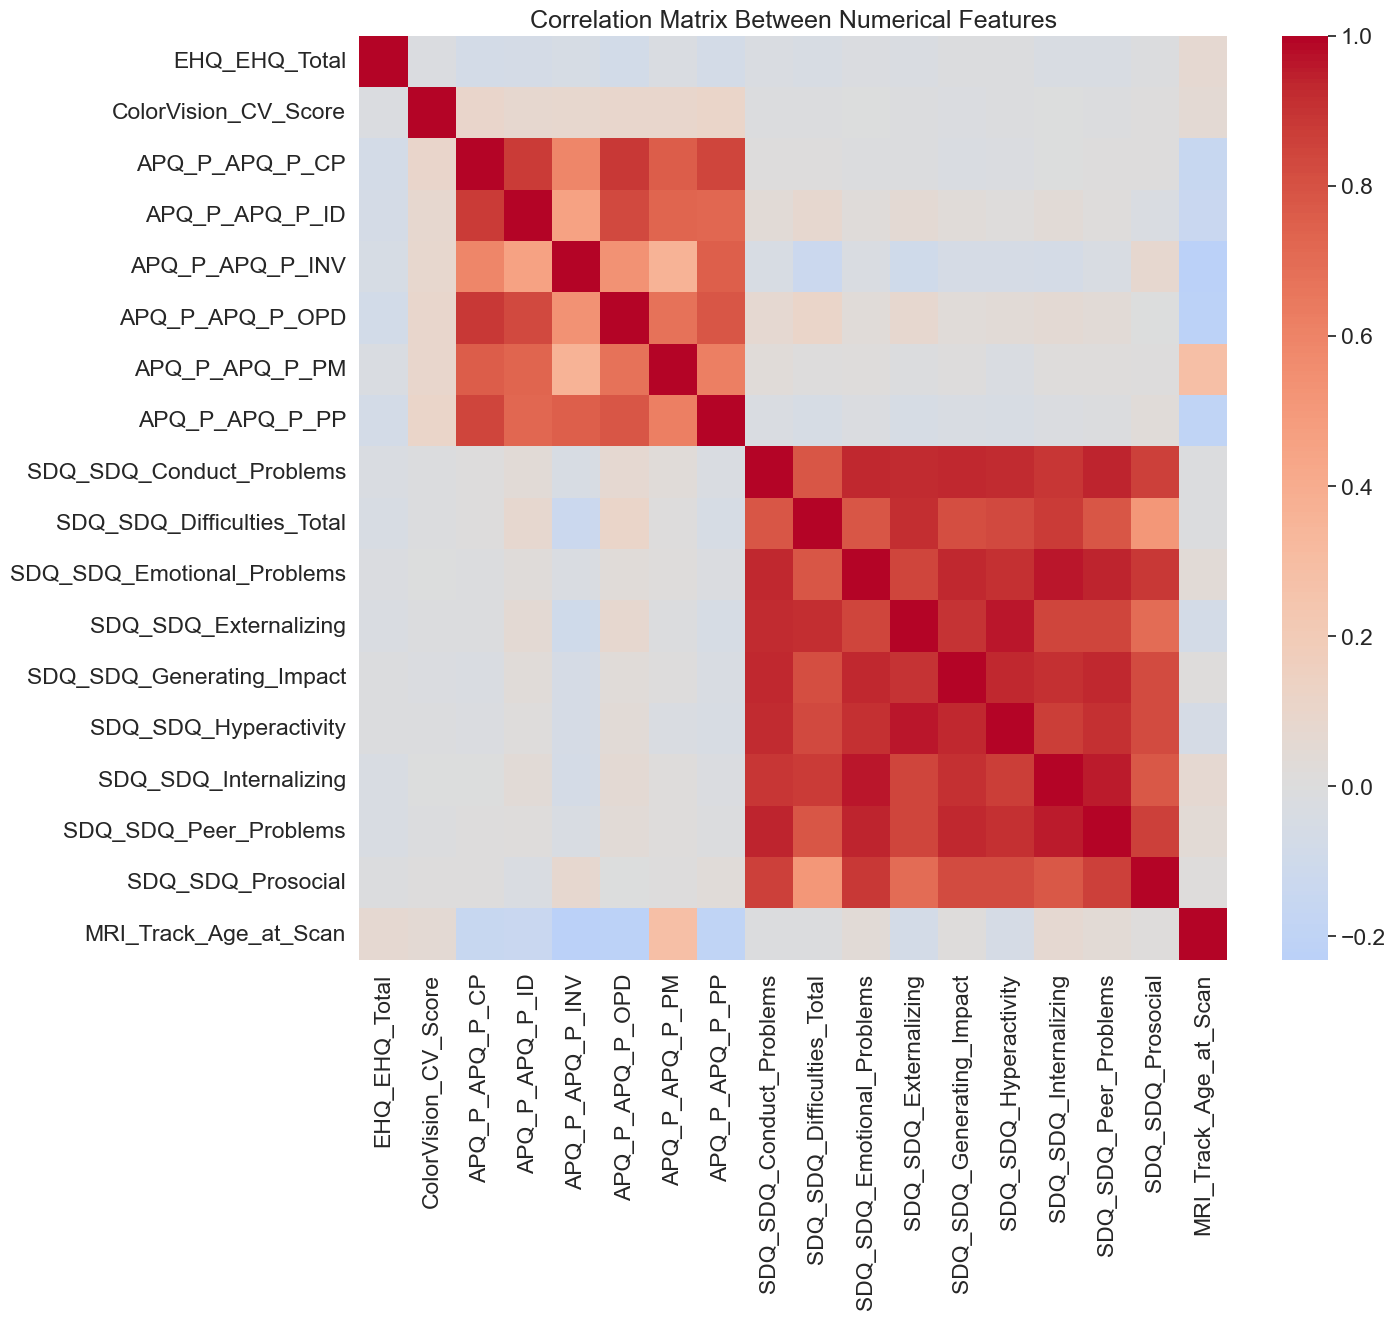

In [38]:
from sklearn.feature_selection import mutual_info_classif, f_classif, chi2, VarianceThreshold
from sklearn.preprocessing import MinMaxScaler

y_adhd = labels['ADHD_Outcome']
y_sex = labels['Sex_F']

plt.figure(figsize=(14, 12))
corr_matrix = train_combined[numerical_features].corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title("Correlation Matrix Between Numerical Features")
plt.show()

In [51]:
# 2. Pearson Correlation with Targets (numerical only)
# ====================
print("=== Pearson Correlation with ADHD ===")
print(train_combined[train_combined.columns].corrwith(y_adhd).sort_values(ascending=False))

print("\n=== Pearson Correlation with Sex_F ===")
print(train_combined[train_combined.columns].corrwith(y_sex).sort_values(ascending=False))

=== Pearson Correlation with ADHD ===
SDQ_SDQ_Difficulties_Total               0.319902
SDQ_SDQ_Externalizing                    0.251713
SDQ_SDQ_Hyperactivity                    0.187534
SDQ_SDQ_Generating_Impact                0.124108
MRI_Track_Scan_Location_3.0              0.123520
Basic_Demos_Enroll_Year_2018             0.103601
SDQ_SDQ_Internalizing                    0.085309
Basic_Demos_Enroll_Year_2019             0.076068
Basic_Demos_Study_Site_3                 0.072041
SDQ_SDQ_Conduct_Problems                 0.038396
Basic_Demos_Study_Site_2                 0.035768
Laterality_Category_Right-Lateralized    0.034193
APQ_P_APQ_P_OPD                          0.034082
PreInt_Demos_Fam_Child_Race_White        0.030042
Barratt_Barratt_P1_Occ                   0.029430
APQ_P_APQ_P_ID                           0.025636
SDQ_SDQ_Peer_Problems                    0.024009
SDQ_SDQ_Emotional_Problems               0.022092
EHQ_EHQ_Total                            0.020383
PreInt_Demos

In [52]:
# 3. Mutual Information (numerical + categorical)
# ====================
mi_adhd = mutual_info_classif(train_combined, y_adhd, discrete_features='auto', random_state=42)
mi_sex = mutual_info_classif(train_combined, y_sex, discrete_features='auto', random_state=42)

mi_df = pd.DataFrame({
    "Feature": train_combined.columns,
    "MI_ADHD": mi_adhd,
    "MI_Sex": mi_sex
}).set_index("Feature")

print("\n=== Mutual Information Scores ===")
print(mi_df.sort_values(by="MI_Sex", ascending=False))


=== Mutual Information Scores ===
                                        MI_ADHD    MI_Sex
Feature                                                  
APQ_P_APQ_P_INV                        0.024348  0.037693
MRI_Track_Scan_Location_3.0            0.005260  0.025928
ColorVision_CV_Score                   0.003688  0.024021
SDQ_SDQ_Hyperactivity                  0.179440  0.021745
Basic_Demos_Enroll_Year_2017           0.009223  0.019196
SDQ_SDQ_Prosocial                      0.017754  0.016901
Barratt_Barratt_P2_Occ                 0.000000  0.015520
PreInt_Demos_Fam_Child_Race_White      0.000000  0.012702
APQ_P_APQ_P_ID                         0.011250  0.012598
Barratt_Barratt_P1_Occ                 0.003474  0.012362
MRI_Track_Scan_Location_2.0            0.000000  0.012114
SDQ_SDQ_Internalizing                  0.017310  0.010262
SDQ_SDQ_Generating_Impact              0.113685  0.007166
Basic_Demos_Enroll_Year_2018           0.009526  0.005791
APQ_P_APQ_P_PM                       

In [49]:
# 4. ANOVA F-test (numerical vs target)
# ====================
f_adhd, p_adhd = f_classif(train_combined[numerical_features], y_adhd)
f_sex, p_sex = f_classif(train_combined[numerical_features], y_sex)

anova_df = pd.DataFrame({
    "Feature": numerical_features,
    "F_ADHD": f_adhd,
    "p_ADHD": p_adhd,
    "F_Sex": f_sex,
    "p_Sex": p_sex
}).set_index("Feature")

print("\n=== ANOVA F-test Results ===")
print(anova_df.sort_values("F_ADHD", ascending=False))


=== ANOVA F-test Results ===
                                F_ADHD        p_ADHD     F_Sex     p_Sex
Feature                                                                 
SDQ_SDQ_Difficulties_Total  138.059384  2.898296e-30  0.599486  0.438925
SDQ_SDQ_Externalizing        81.918689  5.516211e-19  3.355646  0.067220
SDQ_SDQ_Hyperactivity        44.141902  4.604144e-11  2.051624  0.152302
SDQ_SDQ_Generating_Impact    18.944616  1.459141e-05  0.076002  0.782837
SDQ_SDQ_Prosocial            13.350997  2.693333e-04  4.057683  0.044192
APQ_P_APQ_P_INV              12.816153  3.572385e-04  1.113158  0.291607
SDQ_SDQ_Internalizing         8.877887  2.943999e-03  2.340305  0.126326
APQ_P_APQ_P_PP                2.158405  1.420515e-01  0.058033  0.809673
ColorVision_CV_Score          1.961144  1.616472e-01  0.807073  0.369166
SDQ_SDQ_Conduct_Problems      1.787929  1.814297e-01  0.010206  0.919547
APQ_P_APQ_P_OPD               1.408310  2.355699e-01  0.000818  0.977187
APQ_P_APQ_P_CP       

In [ ]:
# ====================
# 5. Chi² Test (categorical vs. target)
# ====================
# scale features to [0, 1] for chi² test
scaler = MinMaxScaler()
X_cat_scaled = pd.DataFrame(scaler.fit_transform(train_combined[cat_features]), columns=cat_features)

chi2_adhd, p_adhd = chi2(X_cat_scaled, y_adhd)
chi2_sex, p_sex = chi2(X_cat_scaled, y_sex)

chi2_df = pd.DataFrame({
    "Feature": cat_features,
    "Chi2_ADHD": chi2_adhd,
    "p_ADHD": p_adhd,
    "Chi2_Sex": chi2_sex,
    "p_Sex": p_sex
}).set_index("Feature")

print("\n=== Chi² Test Results ===")
print(chi2_df.sort_values("Chi2_ADHD", ascending=False))

# 3+: Feature Engineering (Model-Specific)

+ Recursive Feature Elimination (RFE): Starts with all features, trains a model (e.g., Logistic Regression, SVM, or a Tree-based model), removes the least important feature(s) based on coefficients or feature importance scores, and repeats until the desired number of features is reached. The importance is evaluated based on the model's performance on a validation set using the weighted F1 score.

+ Sequential Feature Selection (SFS): Forward Selection: Starts with no features, iteratively adds the feature that results in the best model performance (using the weighted F1 score) until no further improvement is seen.
OR
Backward Elimination: Starts with all features, iteratively removes the feature whose removal least degrades (or most improves) model performance (using the weighted F1 score).

## Embedded Methods (Model-Integrated) 
+ L1 Regularization (Lasso): Used with linear models like Logistic Regression. Adds a penalty proportional to the absolute value of the coefficients. This forces some coefficients to become exactly zero, effectively1 removing those features from the model. You can train a Logistic Regression model with L1 penalty and select the features with non-zero coefficients.   

+ Tree-Based Feature Importance: Models like Random Forest, Gradient Boosting Machines (XGBoost, LightGBM, CatBoost) naturally compute feature importance scores during training (e.g., based on Gini impurity reduction or the number of times a feature is used to split). Train a multi-output tree-based model and use these importance scores to rank and select features. Features with low importance can be dropped.

# 4. Modeling 

+ Logistic Regression: likely to converge to a point due to its simplistic architecture, despite how many feature engineering you did 

+ MLP: The depth of the network allows for hierarchical feature learning, which is particularly useful for complex non-linearities. Each layer the model learns new features, but it is a black box and we as humans cannot interpret what those features are

+ Tree-based algorithm: Gradient Boosting Machines (GBM) (e.g., XGBoost, LightGBM, CatBoost): These are also ensemble methods that build trees sequentially, with each new tree trying to correct the errors made by the previous ones. They are highly effective at capturing intricate non-linear patterns and often achieve state-of-the-art performance

+ Support Vector Machines with non-linear kernels: By using kernel functions (like Radial Basis Function (RBF), polynomial, or sigmoid), SVMs can implicitly map the data into a higher-dimensional space where it might become linearly separable. This allows them to learn complex non-linear decision boundaries in the original feature space

In [ ]:
from sklearn.metrics import classification_report, brier_score_loss, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV

def eval_metrics(y_true, y_pred, weights, label="None", threshold=0.6):
    brier = brier_score_loss(y_true, y_pred)
    f1 = f1_score(y_true, (y_pred > threshold).astype(int), sample_weight=weights)
    print(f"{label} -> Brier Score: {brier:.4f}, F1: {f1:.4f}")
    print(classification_report(y_true, (y_pred > threshold).astype(int), sample_weight=weights))
    return brier, f1

In [ ]:
y_adhd = labels['ADHD_Outcome']
y_sex = labels['Sex_F']

combinations = y_adhd.astype(str) + y_sex.astype(str)

features = train_combined.columns

In [ ]:
numerical_features

In [ ]:
from sklearn.preprocessing import StandardScaler   
scaler = StandardScaler()
train_combined[numerical_features] = scaler.fit_transform(train_combined[numerical_features])
test_combined[numerical_features] = scaler.transform(test_combined[numerical_features])

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_sex)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_sex)
class_weights_dict = dict(zip(classes, weights))

In [ ]:
class_weights_dict

In [ ]:
from catboost import CatBoostClassifier

REPEATS = 5
FOLDS = 5

# Initialize out-of-fold arrays and scores
sex_oof = np.zeros(len(y_sex))
adhd_oof = np.zeros(len(y_adhd))
scores_sex = []
scores_adhd = []

t_sex = 0.3
t_adhd = 0.4

rskf = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=REPEATS, random_state=SEED)
skf = StratifiedKFold(n_splits=FOLDS)

params = {
    "penalty": "l1",
    "Cs": 10,
    "cv": skf,
    "fit_intercept": True,
    "scoring": "f1",
    "random_state": SEED,
    "solver": "saga",
    "class_weight": "balanced"  
}

model_adhd = LogisticRegressionCV(**params)
model_sex = LogisticRegressionCV(**params)
# # CatBoost for predicting sex (classification)
# model_sex = CatBoostClassifier(
#     iterations=5000,
#     learning_rate=0.05,
#     depth=6,
#     loss_function='Logloss',
#     eval_metric='F1',
#     random_seed=SEED,
#     verbose=0,               # Set to 100 if you want logs
#     class_weights= class_weights_dict,
# )

In [ ]:
for fold, (train_idx, val_idx) in enumerate(rskf.split(train_combined, combinations), 1):
    print(f"\n=== Fold {fold} ===")
    X_train, X_val = train_combined.iloc[train_idx].copy(), train_combined.iloc[val_idx].copy()
    y_train_adhd, y_val_adhd = y_adhd.iloc[train_idx], y_adhd.iloc[val_idx]
    y_train_sex, y_val_sex = y_sex.iloc[train_idx], y_sex.iloc[val_idx]
    
    # Sample weights: 2x weight for "11" (female ADHD) cases, per competition requirements
    weights_train = np.where(combinations.iloc[train_idx] == "11", 2, 1)
    weights = np.where(combinations.iloc[val_idx] == "11", 2, 1)
    
    # ----- First Stage: ADHD Model -----
    model_adhd.fit(X_train[features], y_train_adhd, sample_weight=weights_train)
    adhd_train = model_adhd.predict_proba(X_train[features])[:, 1]
    adhd_val   = model_adhd.predict_proba(X_val[features])[:, 1]
    adhd_oof[val_idx] += adhd_val / REPEATS
    adhd_brier, adhd_f1 = eval_metrics(y_val_adhd, adhd_val, weights, "ADHD", t_adhd)
    scores_adhd.append((adhd_brier, adhd_f1))

    model_sex.fit(X_train[features], y_train_sex, sample_weight=weights_train)
    sex_val = model_sex.predict_proba(X_val[features])[:, 1]
    sex_oof[val_idx] += sex_val / REPEATS
    sex_brier, sex_f1 = eval_metrics(y_val_sex, sex_val, weights, "Sex_F", t_sex)
    scores_sex.append((sex_brier, sex_f1))

In [ ]:
print(f"\n=== CV Results ===")
print(f"Sex Mean Brier Score: {np.mean([s[0] for s in scores_sex]):.4f}")
print(f"Sex Mean F1: {np.mean([s[1] for s in scores_sex]):.4f}")
print(f"ADHD Mean Brier Score: {np.mean([s[0] for s in scores_adhd]):.4f}")
print(f"ADHD Mean F1: {np.mean([s[1] for s in scores_adhd]):.4f}")

In [ ]:
weights = ((y_adhd == 1) & (y_sex == 1)) + 1
thresholds = np.linspace(0, 1, 100)

# ADHD threshold optimization
adhd_scores = [f1_score(y_adhd, (adhd_oof > t).astype(int), sample_weight=weights) for t in thresholds]
best_adhd_threshold = thresholds[np.argmax(adhd_scores)]
best_adhd_score = max(adhd_scores)

# Sex threshold optimization
sex_scores = [f1_score(y_sex, (sex_oof > t).astype(int), sample_weight=weights) for t in thresholds]
best_sex_threshold = thresholds[np.argmax(sex_scores)]
best_sex_score = max(sex_scores)

In [ ]:
print(best_sex_threshold)
print(best_adhd_threshold)

# 5. Inference / Evaluation

In [ ]:
model_adhd.fit(train_combined[features], y_adhd, sample_weight=weights)
adhd_proba_train = model_adhd.predict_proba(train_combined[features])[:, 1]
adhd_proba_test = model_adhd.predict_proba(test_combined[features])[:, 1]

model_sex.fit(train_combined[features], y_sex, sample_weight=weights)
sex_proba_test = model_sex.predict_proba(test_combined[features])[:, 1]

In [ ]:
submission = pd.read_excel("data/SAMPLE_SUBMISSION.xlsx")
submission["ADHD_Outcome"] = np.where(adhd_proba_test > best_adhd_threshold, 1, 0)
submission["Sex_F"] = np.where(sex_proba_test > best_sex_threshold, 1, 0)
# Compare share of predicted labels at thresholds between OOF and Test
print(f"Share ADHD OOF: {np.mean(np.where(adhd_oof > best_adhd_threshold, 1, 0)):.4f} - Share ADHD Test: {submission.ADHD_Outcome.mean():.4f}")
print(f"Share Sex_F OOF: {np.mean(np.where(sex_oof > best_sex_threshold, 1, 0)):.4f} - Share Sex_F Test: {submission.Sex_F.mean():.4f}")

submission.to_csv("submission2.csv", index=False)